# Data Science Research Project A - Radio Frequency Communication Channel Model
## 1. Data Loading and preprocesing

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
import warnings
warnings.simplefilter("ignore", category=FutureWarning)

# Set random seed
seed = 22
np.random.seed(seed)
random.seed(seed)

# Set display options to prevent auto line wrapping
pd.set_option('display.expand_frame_repr', False)  

file_path = 'RFLFSODataFull.csv'  
data = pd.read_csv(file_path)

print("data info:")
print(data.info())
print("\ndata head:")
print(data.head())
print("\ndata distribution:")
print(data.describe())
print("\n SYNOPCode count:")
print(data['SYNOPCode'].value_counts())

X = data.drop(columns=['RFL_Att', 'FSO_Att'])
y = data['RFL_Att']

# Split training and test sets based on different weather condition levels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22, stratify=data['SYNOPCode'])

data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91379 entries, 0 to 91378
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   FSO_Att                91379 non-null  float64
 1   RFL_Att                91379 non-null  float64
 2   AbsoluteHumidity       91379 non-null  float64
 3   AbsoluteHumidityMax    91379 non-null  float64
 4   AbsoluteHumidityMin    91379 non-null  float64
 5   Distance               91379 non-null  float64
 6   Frequency              91379 non-null  int64  
 7   Particulate            91379 non-null  float64
 8   ParticulateMax         91379 non-null  float64
 9   ParticulateMin         91379 non-null  float64
 10  RainIntensity          91379 non-null  float64
 11  RainIntensityMax       91379 non-null  float64
 12  RainIntensityMin       91379 non-null  float64
 13  RelativeHumidity       91379 non-null  float64
 14  SYNOPCode              91379 non-null  int6

## 2. Method 1. Generic Random Forest model
### 2.1 Feature selection

In [2]:
def feature_selection_generic(X_train, y_train, target_variable):
    print("\nProcessing Generic Model")
    
    # Perform One-hot encoding on SYNOPCode
    X_train = pd.get_dummies(X_train, columns=['SYNOPCode'], drop_first=True)

    # Initialise result lists
    results = []
    removed_features = []
    ordered_features = []  # List to store remaining features
    last_removed_feature = None  # To store the least important feature found in the previous round

    # Feature selection process
    iteration = 1  # Initialise iteration counter
    while X_train.shape[1] > 0:
        # Define the Random Forest model, using OOB score
        rf = RandomForestRegressor(n_estimators=50, oob_score=True, random_state=22)
        rf.fit(X_train, y_train)

        # Get feature importances
        importances = rf.feature_importances_
        least_important_feature_index = np.argmin(importances)

        # Calculate OOB RMSE and R² for the current model
        oob_pred = rf.oob_prediction_ 
        rmse = mean_squared_error(y_train, oob_pred, squared=False)
        r2 = r2_score(y_train, oob_pred)

        # Store results
        results.append((rmse, r2))
        least_important_feature = X_train.columns[least_important_feature_index]
        removed_features.append(least_important_feature)

        # Print model performance
        print(f"Iteration {iteration}: OOB RMSE = {rmse:.4f}, OOB R² = {r2:.4f}")

        # Print the number of remaining features based on iteration
        if iteration == 1:
            print(f"Remaining features: {X_train.shape[1]}")  # Show total feature count in the first round
        else:
            print(f"Removed feature: {last_removed_feature}. Remaining features: {X_train.shape[1]}")  # Show removed feature and remaining count in subsequent rounds
            
        last_removed_feature = least_important_feature  # Store the least important feature found in the previous round

        # Remove the least important feature
        X_train = X_train.drop(columns=[least_important_feature])

        # Add to the ordered_features list
        ordered_features.append(least_important_feature)

        iteration += 1  # Increment the iteration counter

    # Add the last remaining feature
    if X_train.shape[1] > 0:
        ordered_features.append(X_train.columns[0])  # Assuming only one feature remains at this point

    # Extract RMSE and R² values
    rmse_values = [result[0] for result in results]
    r2_values = [result[1] for result in results]

    # Plot the line chart
    fig, ax1 = plt.subplots(figsize=(10, 5))

    # Plot RMSE line chart
    ax1.set_xlabel('Removed Features', fontsize=14)
    ax1.set_ylabel('RMSE(dB)', color='tab:red', fontsize=14)
    ax1.plot(range(len(rmse_values)), rmse_values, color='tab:red', marker='o', label='RMSE')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    # Create a second y-axis to plot the R² line chart
    ax2 = ax1.twinx()
    ax2.set_ylabel('R²', color='tab:blue', fontsize=14)
    ax2.plot(range(len(r2_values)), r2_values, color='tab:blue', marker='o', label='R²')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    # Set x-axis ticks and labels
    ax1.set_xticks(range(len(rmse_values)))
    ax1.set_xticklabels(ordered_features, rotation=45, ha='right', fontsize=12)  

    # Add title and legend
    plt.title(f'Generic Model Performance for {target_variable} Attenuation', fontsize=16)
    # Set font size for x-axis ticks
    plt.xticks(fontsize=14) 
    fig.tight_layout() 
    plt.show()

    # Return the ordered_features list
    return ordered_features


Processing Generic Model
Iteration 1: OOB RMSE = 0.5463, OOB R² = 0.9747
Remaining features: 30
Iteration 2: OOB RMSE = 0.5474, OOB R² = 0.9746
Removed feature: SYNOPCode_3. Remaining features: 29
Iteration 3: OOB RMSE = 0.5459, OOB R² = 0.9747
Removed feature: SYNOPCode_7. Remaining features: 28
Iteration 4: OOB RMSE = 0.5467, OOB R² = 0.9747
Removed feature: SYNOPCode_4. Remaining features: 27
Iteration 5: OOB RMSE = 0.5464, OOB R² = 0.9747
Removed feature: SYNOPCode_6. Remaining features: 26
Iteration 6: OOB RMSE = 0.5432, OOB R² = 0.9750
Removed feature: SYNOPCode_5. Remaining features: 25
Iteration 7: OOB RMSE = 0.5472, OOB R² = 0.9746
Removed feature: SYNOPCode_8. Remaining features: 24
Iteration 8: OOB RMSE = 0.5441, OOB R² = 0.9749
Removed feature: WindDirection. Remaining features: 23
Iteration 9: OOB RMSE = 0.5463, OOB R² = 0.9747
Removed feature: WindSpeedMin. Remaining features: 22
Iteration 10: OOB RMSE = 0.5424, OOB R² = 0.9750
Removed feature: WindSpeedMax. Remaining fe

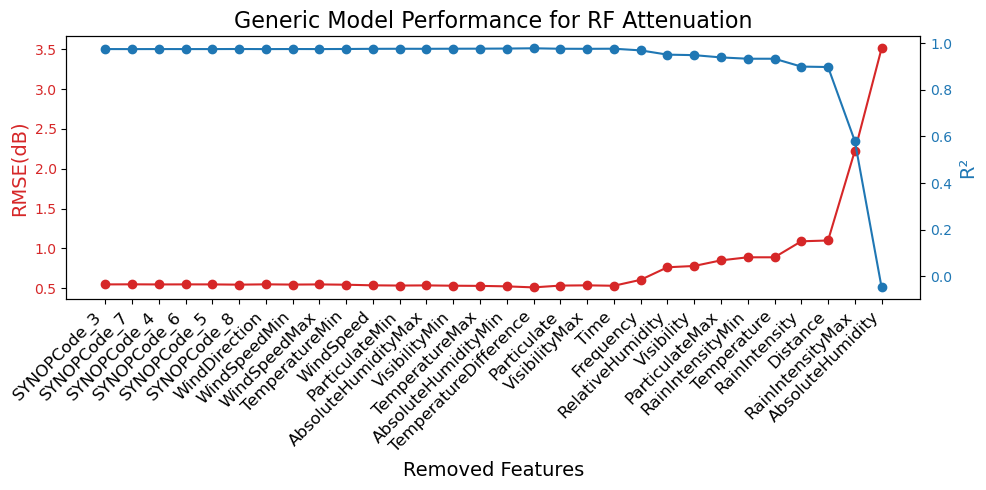

In [3]:
generic_ordered_feature = feature_selection_generic(X_train, y_train, "RF")

In [4]:
generic_selected_features = generic_ordered_feature[-11:]
print(generic_selected_features)

['Time', 'Frequency', 'RelativeHumidity', 'Visibility', 'ParticulateMax', 'RainIntensityMin', 'Temperature', 'RainIntensity', 'Distance', 'RainIntensityMax', 'AbsoluteHumidity']


### 2.2 Hyperparameter optimisation

In [5]:
def tune_hyperparameters(X_train, y_train, selected_features):
    
    # Train using the selected features passed in
    X_train_selected = X_train[selected_features]
    
    # Define the Random Forest model
    rf = RandomForestRegressor(oob_score=True, random_state=22)

    # Hyperparameter tuning
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20]
    }
    
    # Perform hyperparameter tuning using cross-validation
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train_selected, y_train)

    # Get the best hyperparameter combination
    best_params = grid_search.best_params_
    print(f"Best parameters: {best_params}")

    return best_params

In [6]:
# Use the 11 most important features for hyperparameter tuning
best_params = tune_hyperparameters(X_train, y_train, generic_selected_features)

/Users/elise/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters: {'max_depth': None, 'n_estimators': 200}


### 2.3 Train and evalute the generic RF model with the best hyperparameter values

In [ ]:
# Weather condition mapping
condition_map = {
    0: 'Clear',
    3: 'Dust Storm',
    4: 'Fog',
    5: 'Drizzle',
    6: 'Rain',
    7: 'Snow',
    8: 'Showers'
}

In [7]:
def train_and_evaluate_best_generic_rf_model(X_train, y_train, X_test, y_test, selected_features, best_params):
   
    # Train using the selected features passed in
    X_train_copy = X_train.copy()  # Start with selected features (make a copy)
    X_train_selected = X_train[selected_features]
    X_test_selected = X_test[selected_features]

    # Define the model using the best hyperparameter combination
    generic_RF_model = RandomForestRegressor(
        n_estimators=best_params['n_estimators'],
        max_depth=best_params['max_depth'],
        oob_score=True,
        random_state=22
    )

    # Train the model on the training set
    generic_RF_model.fit(X_train_selected, y_train)
    
    # Make predictions on the training set
    y_train_pred = generic_RF_model.predict(X_train_selected)

    # Calculate RMSE and R² for the training set
    train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
    train_r2 = r2_score(y_train, y_train_pred)

    # Make predictions on the test set
    y_test_pred = generic_RF_model.predict(X_test_selected)
    
    # Calculate RMSE and R² for the test set
    rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
    r2_test = r2_score(y_test, y_test_pred)
    
    # OOB evaluation
    oob_rmse = mean_squared_error(y_train, generic_RF_model.oob_prediction_, squared=False)
    oob_r2 = r2_score(y_train, generic_RF_model.oob_prediction_)

    # Add RF_Att_pred to the original dataset
    data.loc[X_train.index, 'RF_Att_pred'] = y_train_pred  # This updates the 'RF_Att_pred' in 'data'

    # Add RF_Att_pred to the copied dataset (X_train_copy) 
    X_train_copy['RF_Att_pred'] = y_train_pred  # Now RF_Att_pred is part of X_train_copy
    
    # Print the results for the training and test sets
    print(f"Training RMSE of generic RF model: {train_rmse:.4f}")
    print(f"Training R² of generic RF model: {train_r2:.4f}")
    print(f"OOB RMSE of generic RF model: {oob_rmse:.4f}")
    print(f"OOB R² of generic RF model: {oob_r2:.4f}")
    print(f"Test RMSE of generic RF model: {rmse_test:.4f}")
    print(f"Test R² of generic RF model: {r2_test:.4f}")

    
    # Store predictions and actual values by condition
    condition_predictions = {0: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: []}
    actual_values = {0: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: []}
    
    # Iterate over X_test
    for index, row in X_test.iterrows():
        condition = row['SYNOPCode']
        if condition in condition_predictions:
            condition_predictions[condition].append(y_test_pred[X_test.index.get_loc(index)])  # Get the corresponding prediction value
            actual_values[condition].append(y_test.iloc[X_test.index.get_loc(index)])  # Get the corresponding actual value

    # Calculate RMSE and R² for each weather condition
    gene_condition_results = {}
    
    # Weather condition mapping
    condition_map = {
        0: 'Clear',
        3: 'Dust Storm',
        4: 'Fog',
        5: 'Drizzle',
        6: 'Rain',
        7: 'Snow',
        8: 'Showers'
    }
    
    for condition in condition_predictions.keys():
        if condition_predictions[condition]:  
            rmse = np.sqrt(mean_squared_error(actual_values[condition], condition_predictions[condition]))
            r2 = r2_score(actual_values[condition], condition_predictions[condition])
            
            # Store RMSE and R² in the dictionary
            gene_condition_results[condition_map[condition]] = {
                'RMSE': rmse,
                'R²': r2
            }

            # Print the results
            print(f' Weather condition {condition_map[condition]}: RMSE = {rmse:.4f}, R² = {r2:.4f}')

    return rmse_test, r2_test, gene_condition_results, generic_RF_model, X_train_copy

In [8]:
# Train the generic model with the best parameters
rmse_test, r2_test, gene_condition_results, generic_RF_model, X_train_copy = train_and_evaluate_best_generic_rf_model(X_train, y_train, X_test, y_test, generic_selected_features, best_params)

Training RMSE of generic RF model: 0.1918
Training R² of generic RF model: 0.9969
OOB RMSE of generic RF model: 0.5181
OOB R² of generic RF model: 0.9772
Test RMSE of generic RF model: 0.4824
Test R² of generic RF model: 0.9804
 Weather condition Clear: RMSE = 0.3069, R² = 0.9854
 Weather condition Dust Storm: RMSE = 0.2729, R² = 0.9915
 Weather condition Fog: RMSE = 0.2519, R² = 0.9747
 Weather condition Drizzle: RMSE = 0.4455, R² = 0.9758
 Weather condition Rain: RMSE = 0.7166, R² = 0.9693
 Weather condition Snow: RMSE = 0.3837, R² = 0.9204
 Weather condition Showers: RMSE = 0.9774, R² = 0.9035


From the hyperpararmeter tuning in generic model, we find the best hyperparameters are: {'max_depth': 20, 'n_estimators': 200}. So we will use it as the model structure.

In [32]:
X_test['SYNOPCode'].value_counts()

0    17089
6     7505
5     1982
8      515
4      140
7      126
3       57
Name: SYNOPCode, dtype: int64

# Part B. FSO model

## 1. Update the target variable and Feature Selection


Processing Generic Model
Iteration 1: OOB RMSE = 0.8900, OOB R² = 0.9481
Remaining features: 31
Iteration 2: OOB RMSE = 0.8891, OOB R² = 0.9482
Removed feature: SYNOPCode_4. Remaining features: 30
Iteration 3: OOB RMSE = 0.8888, OOB R² = 0.9482
Removed feature: SYNOPCode_7. Remaining features: 29
Iteration 4: OOB RMSE = 0.8897, OOB R² = 0.9481
Removed feature: SYNOPCode_8. Remaining features: 28
Iteration 5: OOB RMSE = 0.8909, OOB R² = 0.9480
Removed feature: Frequency. Remaining features: 27
Iteration 6: OOB RMSE = 0.8879, OOB R² = 0.9483
Removed feature: SYNOPCode_6. Remaining features: 26
Iteration 7: OOB RMSE = 0.8883, OOB R² = 0.9483
Removed feature: RainIntensity. Remaining features: 25
Iteration 8: OOB RMSE = 0.8894, OOB R² = 0.9482
Removed feature: SYNOPCode_5. Remaining features: 24
Iteration 9: OOB RMSE = 0.8905, OOB R² = 0.9480
Removed feature: RainIntensityMin. Remaining features: 23
Iteration 10: OOB RMSE = 0.8922, OOB R² = 0.9478
Removed feature: SYNOPCode_3. Remaining f

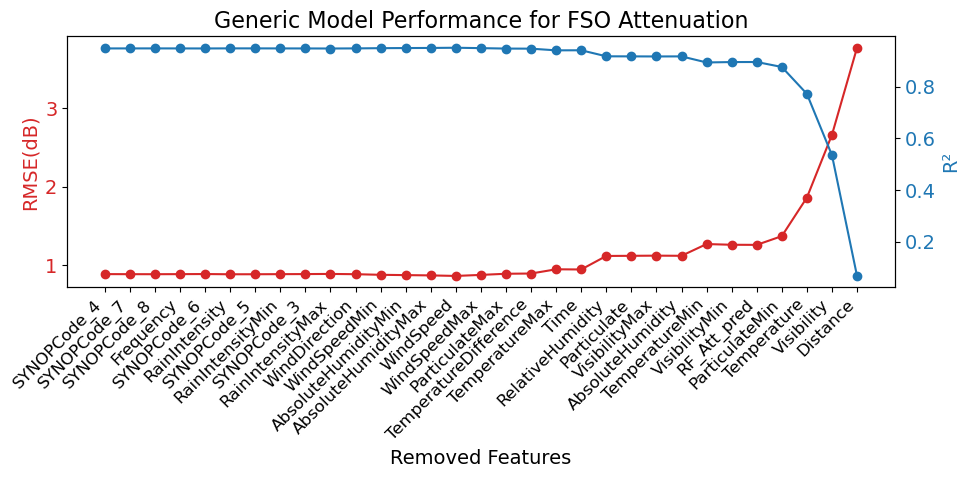

In [ ]:
# Update the target variable y to 'FSO_Att'
y_train_updated = data.loc[X_train_copy.index, 'FSO_Att']

# Perform feature selection to get the ordered feature list
ordered_features = feature_selection_generic(X_train_copy, y_train_updated, "FSO")

In [35]:
# Manually choose the number of features to keep
n_selected_features = 14 

# Select the top n_selected_features
selected_features_for_fso = ordered_features[-n_selected_features:]

# Update X using the newly selected features
X_train_updated = X_train_copy[selected_features_for_fso]

selected_features_for_fso

['TemperatureDifference',
 'TemperatureMax',
 'Time',
 'RelativeHumidity',
 'Particulate',
 'VisibilityMax',
 'AbsoluteHumidity',
 'TemperatureMin',
 'VisibilityMin',
 'RF_Att_pred',
 'ParticulateMin',
 'Temperature',
 'Visibility',
 'Distance']

## 2. Hyperparameter Optimisation and Modelling

In [ ]:
# Use the tune_hyperparameters function to tune hyperparameters
best_params = tune_hyperparameters(X_train_updated, y_train_updated, selected_features_for_fso)

# Define the model with the best hyperparameters
fso_model_tuned = RandomForestRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    random_state=22,
    oob_score=True
)

# Train the model
fso_model_tuned.fit(X_train_updated, y_train_updated)

# Make predictions
y_train_pred_fso_tuned = fso_model_tuned.predict(X_train_updated)

# Calculate RMSE and R² for the training set
train_rmse_fso_tuned = mean_squared_error(y_train_updated, y_train_pred_fso_tuned, squared=False)
train_r2_fso_tuned = r2_score(y_train_updated, y_train_pred_fso_tuned)

# Print training results
print(f"Training RMSE for tuned FSO_Att prediction (using training set): {train_rmse_fso_tuned:.4f}")
print(f"Training R² for tuned FSO_Att prediction (using training set): {train_r2_fso_tuned:.4f}")

/Users/elise/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters: {'max_depth': None, 'n_estimators': 200}
Training RMSE for tuned FSO_Att prediction (using training set): 0.3179
Training R² for tuned FSO_Att prediction (using training set): 0.9934


## 3. Evaluate the models performance on the test set

In [ ]:
# Second phase: Testing phase for the models on test set

# Step 1: Use generic_RF_model to predict RF_Att_pred on test set
def test_generic_rf_model(X_test, y_test, generic_RF_model, data):
    
    # Store predictions and actual values by condition
    condition_predictions = {0: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: []}
    actual_values = {0: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: []}

    # Ensure that RF_Att_pred is added to X_test
    X_test_updated = X_test[generic_selected_features] 
    
    # Predict the RF_Att_pred values on the test set
    y_test_pred_rf = generic_RF_model.predict(X_test_updated) 

    # Add the predicted values to the original dataset
    data.loc[X_test.index, 'RF_Att_pred'] = y_test_pred_rf 
    
    # Ensure RF_Att_pred is added to X_test
    X_test['RF_Att_pred'] = data.loc[X_test.index, 'RF_Att_pred'] 

    # Calculate RMSE and R² for the test set
    test_rmse_rf = mean_squared_error(y_test, y_test_pred_rf, squared=False)
    test_r2_rf = r2_score(y_test, y_test_pred_rf)

    print(f"Test RMSE of generic RF model: {test_rmse_rf:.4f}")
    print(f"Test R² of generic RF model: {test_r2_rf:.4f}")
    
    # Iterate over X_test to store predictions and actual values by SYNOPCode condition
    for index, row in X_test.iterrows():
        condition = row['SYNOPCode']
        if condition in condition_predictions:
            condition_predictions[condition].append(y_test_pred_rf[X_test.index.get_loc(index)])  
            actual_values[condition].append(y_test.iloc[X_test.index.get_loc(index)])  

    # Calculate RMSE and R² for each weather condition
    rf_condition_results = {}
    
    # Weather condition mapping
    condition_map = {
        0: 'Clear',
        3: 'Dust Storm',
        4: 'Fog',
        5: 'Drizzle',
        6: 'Rain',
        7: 'Snow',
        8: 'Showers'
    }
    
    for condition in condition_predictions.keys():
        if condition_predictions[condition]:  
            rmse = np.sqrt(mean_squared_error(actual_values[condition], condition_predictions[condition]))
            r2 = r2_score(actual_values[condition], condition_predictions[condition])
            
            # Store RMSE and R² in the dictionary
            rf_condition_results[condition_map[condition]] = {
                'RMSE': rmse,
                'R²': r2
            }

            # Print the results
            print(f' Generic RF Model - Weather condition {condition_map[condition]}: RMSE = {rmse:.4f}, R² = {r2:.4f}')

    return y_test_pred_rf, test_rmse_rf, test_r2_rf, rf_condition_results

# Perform testing using the generic RF model
y_test_pred_rf, test_rmse_rf, test_r2_rf, rf_condition_results = test_generic_rf_model(X_test, y_test, generic_RF_model, data)

# Step 2: Use fso_rf_model_tuned to predict FSO_Att_pred on test set
def test_fso_rf_model(X_test, y_test, fso_model_tuned, data):
    
    # Store predictions and actual values by condition
    condition_predictions = {0: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: []}
    actual_values = {0: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: []}
    
    X_test_copy = X_test.copy() 
    
    # Ensure that RF_Att_pred is added to X_test
    X_test_updated = X_test[selected_features_for_fso] 
    
    # Update the target variable y to 'FSO_Att'
    y_test_updated = data.loc[X_test.index, 'FSO_Att']  

    # Make predictions for FSO_Att
    y_test_pred_fso = fso_model_tuned.predict(X_test_updated)

    # Calculate RMSE and R² for the FSO_Att predictions
    test_rmse_fso = mean_squared_error(y_test_updated, y_test_pred_fso, squared=False)
    test_r2_fso = r2_score(y_test_updated, y_test_pred_fso)
    
    # Add FSO_Att_pred to the original dataset
    data.loc[X_test.index, 'FSO_Att_pred'] = y_test_pred_fso  

    # Add FSO_Att_pred to the copied dataset (X_train_copy) 
    X_test_copy['FSO_Att_pred'] = y_test_pred_fso  

    print(f"Test RMSE for tuned FSO_Att prediction: {test_rmse_fso:.4f}")
    print(f"Test R² for tuned FSO_Att prediction: {test_r2_fso:.4f}")
    
    # Iterate over X_test to store predictions and actual values by SYNOPCode condition
    for index, row in X_test.iterrows():
        condition = row['SYNOPCode']
        if condition in condition_predictions:
            condition_predictions[condition].append(y_test_pred_fso[X_test.index.get_loc(index)])  
            actual_values[condition].append(y_test_updated.iloc[X_test.index.get_loc(index)]) 
    # Calculate RMSE and R² for each weather condition
    fso_condition_results = {}
    
    for condition in condition_predictions.keys():
        if condition_predictions[condition]:  
            rmse = np.sqrt(mean_squared_error(actual_values[condition], condition_predictions[condition]))
            r2 = r2_score(actual_values[condition], condition_predictions[condition])
            
            # Store RMSE and R² in the dictionary
            fso_condition_results[condition_map[condition]] = {
                'RMSE': rmse,
                'R²': r2
            }

            # Print the results
            print(f' FSO Model - Weather condition {condition_map[condition]}: RMSE = {rmse:.4f}, R² = {r2:.4f}')

    return y_test_pred_fso, test_rmse_fso, test_r2_fso, X_test_copy, fso_condition_results

# Perform testing using the tuned FSO model
y_test_pred_fso, test_rmse_fso, test_r2_fso, X_test_copy, fso_condition_results = test_fso_rf_model(X_test, y_test, fso_model_tuned, data)

data.loc[X_test.index, 'RF_Att_pred'] = y_test_pred_rf  # Save RF_Att_pred for test set
data.loc[X_test.index, 'FSO_Att_pred'] = y_test_pred_fso  # Save FSO_Att_pred for test set

# Display the results
print("\nFinal Results on Test Set:")
print(f"Generic RF Model - Test RMSE: {test_rmse_rf:.4f}, Test R²: {test_r2_rf:.4f}")
print(f"FSO RF Model - Test RMSE: {test_rmse_fso:.4f}, Test R²: {test_r2_fso:.4f}")


Test RMSE of generic RF model: 0.4824
Test R² of generic RF model: 0.9804
 Generic RF Model - Weather condition Clear: RMSE = 0.3069, R² = 0.9854
 Generic RF Model - Weather condition Dust Storm: RMSE = 0.2729, R² = 0.9915
 Generic RF Model - Weather condition Fog: RMSE = 0.2519, R² = 0.9747
 Generic RF Model - Weather condition Drizzle: RMSE = 0.4455, R² = 0.9758
 Generic RF Model - Weather condition Rain: RMSE = 0.7166, R² = 0.9693
 Generic RF Model - Weather condition Snow: RMSE = 0.3837, R² = 0.9204
 Generic RF Model - Weather condition Showers: RMSE = 0.9774, R² = 0.9035
Test RMSE for tuned FSO_Att prediction: 0.8410
Test R² for tuned FSO_Att prediction: 0.9535
 FSO Model - Weather condition Clear: RMSE = 0.8436, R² = 0.9417
 FSO Model - Weather condition Dust Storm: RMSE = 1.6794, R² = 0.9575
 FSO Model - Weather condition Fog: RMSE = 0.7735, R² = 0.9694
 FSO Model - Weather condition Drizzle: RMSE = 0.8130, R² = 0.9465
 FSO Model - Weather condition Rain: RMSE = 0.8174, R² = 0.9

In [42]:
X_test_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27414 entries, 78254 to 85568
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   AbsoluteHumidity       27414 non-null  float64
 1   AbsoluteHumidityMax    27414 non-null  float64
 2   AbsoluteHumidityMin    27414 non-null  float64
 3   Distance               27414 non-null  float64
 4   Frequency              27414 non-null  int64  
 5   Particulate            27414 non-null  float64
 6   ParticulateMax         27414 non-null  float64
 7   ParticulateMin         27414 non-null  float64
 8   RainIntensity          27414 non-null  float64
 9   RainIntensityMax       27414 non-null  float64
 10  RainIntensityMin       27414 non-null  float64
 11  RelativeHumidity       27414 non-null  float64
 12  SYNOPCode              27414 non-null  int64  
 13  Temperature            27414 non-null  float64
 14  TemperatureDifference  27414 non-null  float64
 15

In [46]:
# Find the corresponding actual y values from the original dataset based on the indices of X_test_copy
y_test_RFL = data.loc[X_test_copy.index, 'RFL_Att']
y_test_FSO = data.loc[X_test_copy.index, 'FSO_Att']
y_test_RFL.info()

<class 'pandas.core.series.Series'>
Int64Index: 27414 entries, 78254 to 85568
Series name: RFL_Att
Non-Null Count  Dtype  
--------------  -----  
27414 non-null  float64
dtypes: float64(1)
memory usage: 428.3 KB


In [51]:
y_test_FSO

78254     6.016464
79643     8.738037
15930     7.045450
75588    12.903929
33978     5.589637
           ...    
32185     4.237412
75815     8.346267
82919     7.511418
37593    14.513886
85568    15.369566
Name: FSO_Att, Length: 27414, dtype: float64

In [49]:
# Ensure the two datasets have the same index order
print(X_test_copy.index.equals(y_test_RFL.index))  
print(X_test_copy.index.equals(y_test_FSO.index)) 

True
True


In [50]:
# Merge X_test_copy、y_test_RFL and y_test_FSO
RF_FSO_testset = pd.concat([X_test_copy, y_test_RFL, y_test_FSO], axis=1)
RF_FSO_testset.to_csv("RF_FSO_testset.csv", index=False)